03764090, Tu-Chin Chiang

#### The goal of this homework is to super-resolve a very low resolution image (32x32) to a high resolution image (1024x1024) using a trained image prior as discussed in class. The generative prior used here is a style GAN, its code is already provided, and its trained parameters can be downloaded from: https://drive.google.com/uc?id=1TCViX1YpQyRsklTVYEJwdbmK91vklCo8

#### We start by loading the provided high resolution image, then downscaling it by a factor of 32. We then recover the original high resolution image by minimizing equation 3 in the lecture notes using gradient descent.

In [ ]:
from google.colab import drive
import os

gdrive_path = '/content/gdrive/MyDrive/Colab Notebooks/dlip/HW8/'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['.DS_Store', 'Super_Resolution_GANs_problem.ipynb', '__MACOSX', '__pycache__', 'bicubic.py', 'colab_pdf.py', 'gaussian_fit.pt', 'gt.jpeg', 'stylegan.py', 'synthesis.pt']


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision

from bicubic import BicubicDownSample  #Downscaler
from stylegan import G_synthesis       #style GAN

torch.Size([1, 3, 1024, 1024])


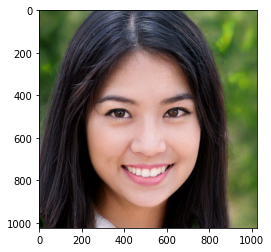

In [ ]:
gt = Image.open(gdrive_path + 'gt.jpeg') #load ground truth high resolution img
gt = torchvision.transforms.ToTensor()(gt)
gt = gt.unsqueeze(0)

print(gt.shape)
plt.imshow(gt.squeeze(0).permute(1,2,0))

In [ ]:
device = 'cuda'
gt = gt.to(device)

torch.Size([1, 3, 32, 32])


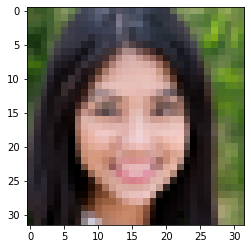

In [ ]:
#Downscaling
A = BicubicDownSample(factor=32)
y = A(gt)
y = y.clamp(0,1)

print(y.shape)
plt.imshow(y.cpu().squeeze(0).permute(1,2,0))

In [ ]:
#Load trained style GAN
model = G_synthesis().to(device)
state_dict = torch.load(gdrive_path + 'synthesis.pt')  #enter path to the downloaded state_dict
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
#Scaling factors
gaussian_fit = torch.load(gdrive_path + "gaussian_fit.pt")
lrelu = torch.nn.LeakyReLU(negative_slope=0.2)

In [ ]:
#Load noise input to GAN, note that z1 is trainable but z2 is kept fixed.

z1 = torch.randn((1, 18, 512), dtype=torch.float, requires_grad=True, device=device)

#Generate list of noise tensors
z2 = [] # stores all of the noise tensors

for i in range(18):
    # dimension of the ith noise tensor
    res = (1, 1, 2**(i//2+2), 2**(i//2+2))

    new_noise = torch.randn(res, dtype=torch.float, device=device)
    new_noise.requires_grad = False

    z2.append(new_noise)

In [ ]:
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#Takes as input noise, and returns an image
def G(z1,z2):
    latent = lrelu(z1*gaussian_fit["std"] + gaussian_fit["mean"])
    img = model(latent, z2) 
    img = (img + 1)/2  
    img = img.clamp(0,1)
    return img 

Write your code to recover the original image by optimizing over $z_1$

Criterion: $\quad \min\limits_{\textbf z} \frac{1}{2}||\textbf A G(\textbf z) - \textbf y||_2^2 + \gamma ||\textbf z||_2^2$


In [ ]:
def ridge_mse(gt, pred, w, weight_decay=1e-6):
    loss = mse(gt, pred)
    # print(w.shape)
    # print(type(w))
    w_flat = w.flatten()
    loss += weight_decay * torch.linalg.norm(w_flat) / w_flat.size()[0]
    return loss

def training_step(z1, z2, ground_truth, learning_rate=1, weight_decay=1e-6, num_steps=10000):
    optimizer = torch.optim.SGD([z1], lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4000,8000], gamma=0.1)
    losses = []

    with tqdm(range(num_steps)) as tepoch:
        for _ in tepoch:
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = G(z1, z2)
            # loss = mse(ground_truth, A(output))
            loss = ridge_mse(ground_truth, A(output), z1, weight_decay)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            tepoch.set_postfix(loss=loss.item())

    return z1, output, losses

z1_opt, rec_img, mse_losses = training_step(z1, z2, y)

  0%|          | 0/10000 [00:00<?, ?it/s]

Plot your final image here

Text(0.5, 1.0, 'ground truth, size: [1, 3, 1024, 1024]')

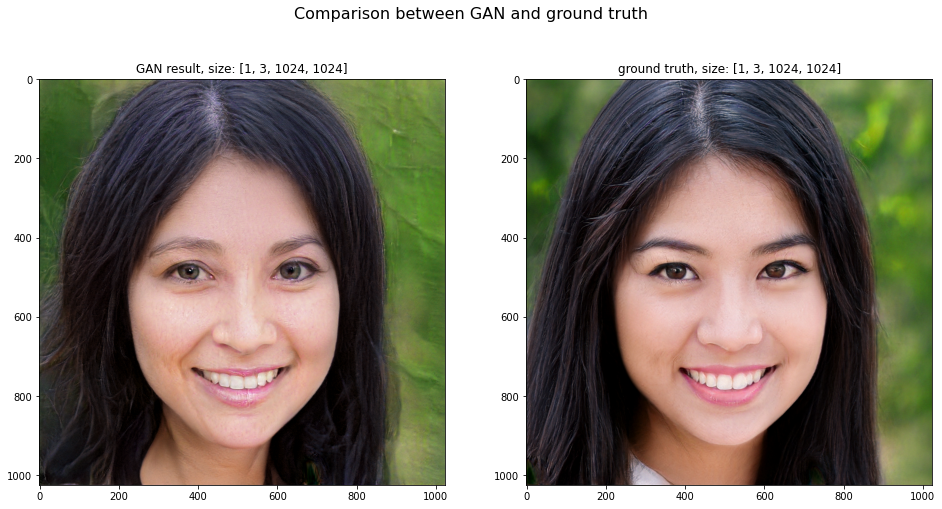

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)
fig.suptitle('Comparison between GAN and ground truth', fontsize=16)

ax[0].imshow(rec_img.cpu().detach().squeeze(0).permute(1,2,0))
ax[0].set_title('GAN result, size: '+ str(list(rec_img.size())))

ax[1].imshow(gt.cpu().squeeze(0).permute(1,2,0))
ax[1].set_title('ground truth, size: '+ str(list(gt.size())))

Print the MSE between your final image and the ground truth here

After 10000 iterations, the loss value = 0.001585


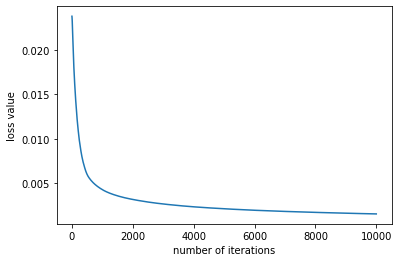

In [ ]:
print('After %d iterations, the loss value = %f' % (len(mse_losses), mse_losses[-1]))
plt.plot(mse_losses)
plt.xlabel('number of iterations')
plt.ylabel('loss value')
plt.show()

### Bonus 
As we can see, the final image looks like a high resolution image of a face, but is not very similar to the ground truth. By additionally optimizing over $z_2$ as well, you can get slightly better results.

For achieving very good results, you can use the code from the following gihub repository: https://github.com/krantirk/Self-Supervised-photo

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/dlip/HW8/
#run these.
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!jupyter nbconvert --to pdf Super_Resolution_GANs_problem.ipynb

/content/drive/MyDrive/Colab Notebooks/dlip/HW8
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-generic-recommended is already the newest version (2017.20180305-1).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.
[NbConvertApp] Converting notebook Super_Resolution_GANs_problem.ipynb to pdf
[NbConvertApp] Support files will be in Super_Resolution_GANs_problem_files/
[NbConvertApp] Making directory ./Super_Resolution_GANs_problem_files
[NbConvertApp] Making directory ./Super_Resolution_GANs_problem_files
[NbConvertApp] Making directory ./Super_Resolution_GANs_problem_files
[NbConvertApp] Making directory ./Super_Resolution_GANs_problem_files
[N